# UKB mutation overview


In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from io import StringIO
import seaborn as sns
import scipy.stats as stats
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 40)
%precision 2

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

### 0- Matrix preparing

In [3]:
### Upload boostDM-CH predictions
Rules_matrix = pd.read_csv('../../../Paper_data/Expert_curated_rules/genes12_BoostdmCH_Harvard_simp_run20230803.tsv.gz', sep='\t', compression='gzip')
Rules_matrix

,gene,chr,pos,alt,Prot_pos,aachange,csqn_type_missense,csqn_type_nonsense,csqn_type_splicing,csqn_type_synonymous,boostDM_score,boostDM_class,Niroula,Bick,CNIC,WHO
0,ASXL1,20,32358779,C,2,K2Q,1,0,0,0,0.000014,0,0.0,0.0,0.0,0.0
1,ASXL1,20,32358779,G,2,K2E,1,0,0,0,0.000014,0,0.0,0.0,0.0,0.0
2,ASXL1,20,32358779,T,2,K2*,0,1,0,0,0.989503,1,0.0,0.0,0.0,0.0
3,ASXL1,20,32358780,C,2,K2T,1,0,0,0,0.000011,0,0.0,0.0,0.0,0.0
4,ASXL1,20,32358780,G,2,K2R,1,0,0,0,0.000011,0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87934,U2AF1,21,43107490,C,2,A2G,1,0,0,0,0.002605,0,0.0,0.0,0.0,0.0
87935,U2AF1,21,43107490,T,2,A2E,1,0,0,0,0.002605,0,0.0,0.0,0.0,0.0
87936,U2AF1,21,43107491,A,2,A2S,1,0,0,0,0.002207,0,0.0,0.0,0.0,0.0
87937,U2AF1,21,43107491,G,2,A2P,1,0,0,0,0.002207,0,0.0,0.0,0.0,0.0


In [5]:
### Read data ch mutations and age (NOT PROVIDED)
# Created in section 1_Post_processing_calling
patient_age_ch = pd.read_csv('../1_Post_processing_calling/patient_450k_age_670124_ALL_MUTATIONS_20230802_v3.txt.gz',sep="\t")
print(f'Patients:{len(patient_age_ch)}')
print(f'Columns:{list(patient_age_ch.columns)}')

Patients:469880
Columns:['patient', 'age_recruitment', 'age_group', 'CH_driver', 'CH_driver_big', 'CH_driver_small', 'CH_potential', 'CH_passengers', 'num_CH_drivers', 'CH_driver_multiple', 'num_CH_potential', 'ASXL1_driver', 'ASXL1_passenger', 'ASXL1_potential', 'CHEK2_driver', 'CHEK2_passenger', 'CHEK2_potential', 'DNMT3A_driver', 'DNMT3A_passenger', 'DNMT3A_potential', 'GNAS_driver', 'GNAS_passenger', 'GNAS_potential', 'IDH2_driver', 'IDH2_passenger', 'IDH2_potential', 'MDM4_driver', 'MDM4_passenger', 'MDM4_potential', 'PPM1D_driver', 'PPM1D_passenger', 'PPM1D_potential', 'SF3B1_driver', 'SF3B1_passenger', 'SF3B1_potential', 'SRSF2_driver', 'SRSF2_passenger', 'SRSF2_potential', 'TET2_driver', 'TET2_passenger', 'TET2_potential', 'TP53_driver', 'TP53_passenger', 'TP53_potential', 'U2AF1_driver', 'U2AF1_passenger', 'U2AF1_potential', 'chromatin_gene_driver', 'DDR_gene_driver', 'splicing_gene_driver', 'chromatin_gene_passenger', 'DDR_gene_passenger', 'splicing_gene_passenger', 'chromati

In [6]:
### Upload UKB mutations (NOT PROVIDED)
# Created in section 1_Post_processing_calling
boostDM_predictions = pd.read_csv('../1_Post_processing_calling/All450k_filtered_boostDM_ALL_age_20230802_v3.vcf', sep="\t", compression='gzip')
boostDM_predictions = boostDM_predictions.rename(columns={'case': 'patient', 'BoostDM':'Drivers_12genes'})
boostDM_predictions = boostDM_predictions[~boostDM_predictions['Prot_pos'].isna()]
boostDM_predictions = boostDM_predictions[~boostDM_predictions['Consequence'].isin(['start_lost', 'stop_lost', 'stop_retained_variant'])]
boostDM_predictions = boostDM_predictions[boostDM_predictions['patient'].isin(patient_age_ch['patient'])]
boostDM_predictions = boostDM_predictions[~boostDM_predictions['ALT'].str.contains(',')]
len(boostDM_predictions)

203351

In [5]:
### Upload general cancer information per case (NOT PROVIDED)
# Created in section 0_Clinical_phenotypes
patient_cancer = pd.read_csv('../../../Paper_data/UKB_clinic_info/cancer_ukb450k_670124.txt.gz', sep="\t")
ukb200K_ch_cancer = pd.merge(patient_age_ch, patient_cancer,  how='inner', on='patient')
ukb200K_ch_cancer.columns

/tmp/jobs/jramis/9874679/ipykernel_48736/1187256820.py:2: DtypeWarning: Columns (36,37,38,44,45,46) have mixed types. Specify dtype option on import or set low_memory=False.
  patient_cancer = pd.read_csv('../../../Paper_data/UKB_clinic_info/cancer_ukb450k_670124.txt.gz', sep="\t")


Index(['patient', 'age_recruitment_x', 'age_group_x', 'CH_driver',
       'CH_driver_big', 'CH_driver_small', 'CH_potential', 'CH_passengers',
       'num_CH_drivers', 'CH_driver_multiple',
       ...
       '22009-0.1', '22009-0.2', '22009-0.3', '22009-0.4', '22009-0.5',
       '22009-0.6', '22009-0.7', '22009-0.8', '22009-0.9', '22009-0.10'],
      dtype='object', length=139)

In [6]:
# Upload Cancer variables per case (NOT PROVIDED)
# Created in section 0_Clinical_phenotypes
patient_cancer = pd.read_csv('../../../Paper_data/UKB_clinic_info/cancer_ukb200k_Siddharta_670124_simple.txt.gz', sep="\t")
patient_cancer = patient_cancer.rename(columns={'eid': 'patient'})
ukb200K_ch_cancer = pd.merge(ukb200K_ch_cancer, patient_cancer,  how='inner', on='patient')
ukb200K_ch_cancer.rename(columns={'CH_passengers':'CH_nonDriver'}, inplace=True)
ukb200K_ch_cancer.columns

Index(['patient', 'age_recruitment_x', 'age_group_x', 'CH_driver',
       'CH_driver_big', 'CH_driver_small', 'CH_potential', 'CH_nonDriver',
       'num_CH_drivers', 'CH_driver_multiple',
       ...
       'var_Cervical_post', 'var_Cervical_pre', 'var_Sarcoma_years',
       'var_Sarcoma_var', 'var_Sarcoma_post', 'var_Sarcoma_pre',
       'var_Testicular_years', 'var_Testicular_var', 'var_Testicular_post',
       'var_Testicular_pre'],
      dtype='object', length=263)

In [7]:
# Create a unique variable for hematological cancer 
yeears = ['var_MM_years', 'var_MPN_years', 'var_MDS_years', 'var_CMML_years',
          'var_AML_years', 'var_LL_years', 'var_Lymphoma_years', 'var_Myeloma_years']
ukb200K_ch_cancer['var_HNALL_years'] = ukb200K_ch_cancer.loc[:,yeears].min(axis=1)
ukb200K_ch_cancer['var_HNALL_var'] = np.where(ukb200K_ch_cancer['var_HNALL_years'].notnull(), 1, 0)
ukb200K_ch_cancer['var_HNALL_post'] = np.where(ukb200K_ch_cancer['var_HNALL_years'] > 0, 1, 0)
ukb200K_ch_cancer['var_HNALL_pre'] = np.where(ukb200K_ch_cancer['var_HNALL_years'] < 0, 1, 0)

In [8]:
ukb200K_ch_cancer = ukb200K_ch_cancer.rename(columns = {'31-0.0':'sex',
                                                                          '22009-0.1':'PC1',
                                                                          '22009-0.2':'PC2',
                                                                          '22009-0.3':'PC3',
                                                                          '22009-0.4':'PC4',
                                                                          '22009-0.5':'PC5',
                                                                          '22009-0.6':'PC6',
                                                                          '22009-0.7':'PC7',
                                                                          '22009-0.8':'PC8',
                                                                          '22009-0.9':'PC9',
                                                                          '22009-0.10':'PC10',
                                                                         })

In [11]:
# Select only those mutations from patients without a previoius hematological cancer
non_HN_patients = ukb200K_ch_cancer[ukb200K_ch_cancer['var_HNALL_pre']==0]['patient'].tolist()
boostDM_predictions_nonHN = boostDM_predictions[boostDM_predictions['patient'].isin(non_HN_patients)].reset_index(drop=True)
len(boostDM_predictions_nonHN)

201857

# 1- Series Description

In [12]:
genes12 = ['DNMT3A', 'TET2', 'ASXL1', 'CHEK2', 'TP53', 'PPM1D', 'SF3B1', 'SRSF2','U2AF1', 'GNAS','IDH2', 'MDM4']

In [13]:
### Describing Series
print(f"Number of potential mutations: {len(boostDM_predictions_nonHN)}")
print(f"Number of driver mutations: {len(boostDM_predictions_nonHN[boostDM_predictions_nonHN['Drivers_12genes']==1])}")
print(f"Number of non-driver mutations: {len(boostDM_predictions_nonHN[boostDM_predictions_nonHN['Drivers_12genes']==0])}")
print()
print(f"Number of cases with driver mutations: {len(ukb200K_ch_cancer[(ukb200K_ch_cancer['CH_driver']==1)&(ukb200K_ch_cancer['var_HNALL_pre']==0)])}")
print(f"Number of cases with potential mutations: {len(ukb200K_ch_cancer[ukb200K_ch_cancer['CH_potential']==1&(ukb200K_ch_cancer['var_HNALL_pre']==0)])}")
print()
print(f"Number of patient with cancer: {len(ukb200K_ch_cancer[ukb200K_ch_cancer['cancer'] == 1])}")
print(f"Number of patient with pre-cancer: {len(ukb200K_ch_cancer[ukb200K_ch_cancer['cancer1_pre'] == 1])}")
print(f"Number of patient with Hematological cancer: {len(ukb200K_ch_cancer[ukb200K_ch_cancer['var_HNALL_var'] == 1])}")
print(f"Number of patient with pre-Hematological cancer: {len(ukb200K_ch_cancer[ukb200K_ch_cancer['var_HNALL_pre'] == 1])}")

Number of potential mutations: 201857
Number of driver mutations: 41306
Number of non-driver mutations: 160551

Number of cases with driver mutations: 38124
Number of cases with potential mutations: 149682

Number of patient with cancer: 110890
Number of patient with pre-cancer: 37495
Number of patient with Hematological cancer: 7992
Number of patient with pre-Hematological cancer: 2678


### Mutational landscape by mutation

In [14]:
non_HN_patients = ukb200K_ch_cancer[ukb200K_ch_cancer['var_HNALL_pre']==0]
unique = set(non_HN_patients[(non_HN_patients['CH_driver_multiple']==0)]['patient'])
multiple = set(non_HN_patients[(non_HN_patients['CH_driver_multiple']==1)]['patient'])

In [15]:
# Mutational landscape by mutation

Mut_case = []
for gene in boostDM_predictions_nonHN['SYMBOL'].unique():
    freq = len(boostDM_predictions_nonHN[boostDM_predictions_nonHN['SYMBOL']==gene])
    freq_driv = len(boostDM_predictions_nonHN[(boostDM_predictions_nonHN['SYMBOL']==gene) & (boostDM_predictions_nonHN['Drivers_12genes']==1)])
    freq_big = len(boostDM_predictions_nonHN[(boostDM_predictions_nonHN['SYMBOL']==gene) & (boostDM_predictions_nonHN['Drivers_12genes']==1) &\
                                       (boostDM_predictions_nonHN['VAF_alt']>=0.1)])
    freq_small = len(boostDM_predictions_nonHN[(boostDM_predictions_nonHN['SYMBOL']==gene) & (boostDM_predictions_nonHN['Drivers_12genes']==1) &\
                                        (boostDM_predictions_nonHN['VAF_alt']<0.1)])
    freq_pass = len(boostDM_predictions_nonHN[(boostDM_predictions_nonHN['SYMBOL']==gene) & (boostDM_predictions_nonHN['Drivers_12genes']==0)])
    freq_driv_uniq = len(boostDM_predictions_nonHN[(boostDM_predictions_nonHN['SYMBOL']==gene) & (boostDM_predictions_nonHN['Drivers_12genes']==1)&\
                                                  (boostDM_predictions_nonHN['patient'].isin(unique))])
    freq_driv_mult = len(boostDM_predictions_nonHN[(boostDM_predictions_nonHN['SYMBOL']==gene) & (boostDM_predictions_nonHN['Drivers_12genes']==1)&\
                                                  (boostDM_predictions_nonHN['patient'].isin(multiple))])

#     freq = len(maf_can_PASS_VAF_nonrep.groupby(['SYMBOL'])['case'].unique()[gene])
    Mut_case.append([gene, freq, freq_driv, freq_big, freq_small, freq_pass,freq_driv_uniq, freq_driv_mult])

In [16]:
Mut_case = pd.DataFrame(Mut_case, columns = ['Gene', 'Cases', 'Drivers', 'Driver_big', 'Driver_small', 'Passangers', 'Driver_single', 'Driver_multiple']).sort_values('Cases', ascending=False)
Mut_case.reset_index()

,index,Gene,Cases,Drivers,Driver_big,Driver_small,Passangers,Driver_single,Driver_multiple
0,1,TET2,40877,9824,2874,6950,31053,8144,1680
1,2,DNMT3A,37042,21547,4801,16746,15495,18731,2816
2,3,ASXL1,35386,2459,443,2016,32927,2112,347
3,10,GNAS,19756,251,137,114,19505,234,17
4,6,PPM1D,13806,877,163,714,12929,735,142
5,7,CHEK2,10867,2212,1613,599,8655,1934,278
6,4,SF3B1,9496,707,318,389,8789,552,155
7,5,TP53,8654,2153,491,1662,6501,1864,289
8,9,IDH2,7902,130,78,52,7772,82,48
9,8,MDM4,6611,114,49,65,6497,99,15


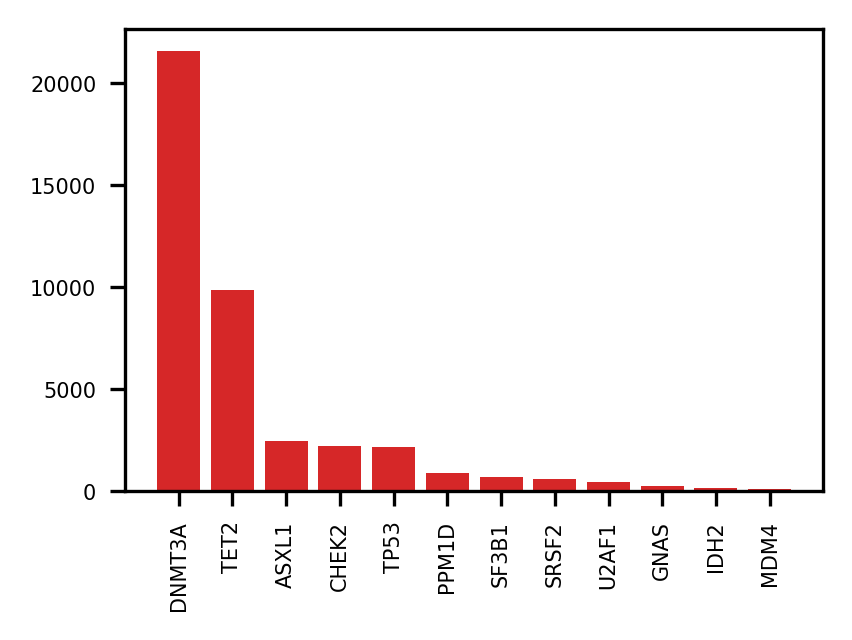

In [17]:
# importing package
import matplotlib.pyplot as plt
plt.figure(figsize=(3, 2), dpi=300)
    
# create data
x = Mut_case.sort_values('Drivers', ascending=False)['Gene']
y2 = Mut_case.sort_values('Drivers', ascending=False)['Drivers']
 
    

# plot bars in stack manner
plt.bar(x, y2, color='tab:red')
plt.yticks(fontsize=5)
plt.xticks(rotation=90,fontsize=5)
plt.show()

### Mutational landscape by mutation and clonality

In [18]:
Mut_case

,Gene,Cases,Drivers,Driver_big,Driver_small,Passangers,Driver_single,Driver_multiple
1,TET2,40877,9824,2874,6950,31053,8144,1680
2,DNMT3A,37042,21547,4801,16746,15495,18731,2816
3,ASXL1,35386,2459,443,2016,32927,2112,347
10,GNAS,19756,251,137,114,19505,234,17
6,PPM1D,13806,877,163,714,12929,735,142
7,CHEK2,10867,2212,1613,599,8655,1934,278
4,SF3B1,9496,707,318,389,8789,552,155
5,TP53,8654,2153,491,1662,6501,1864,289
9,IDH2,7902,130,78,52,7772,82,48
8,MDM4,6611,114,49,65,6497,99,15


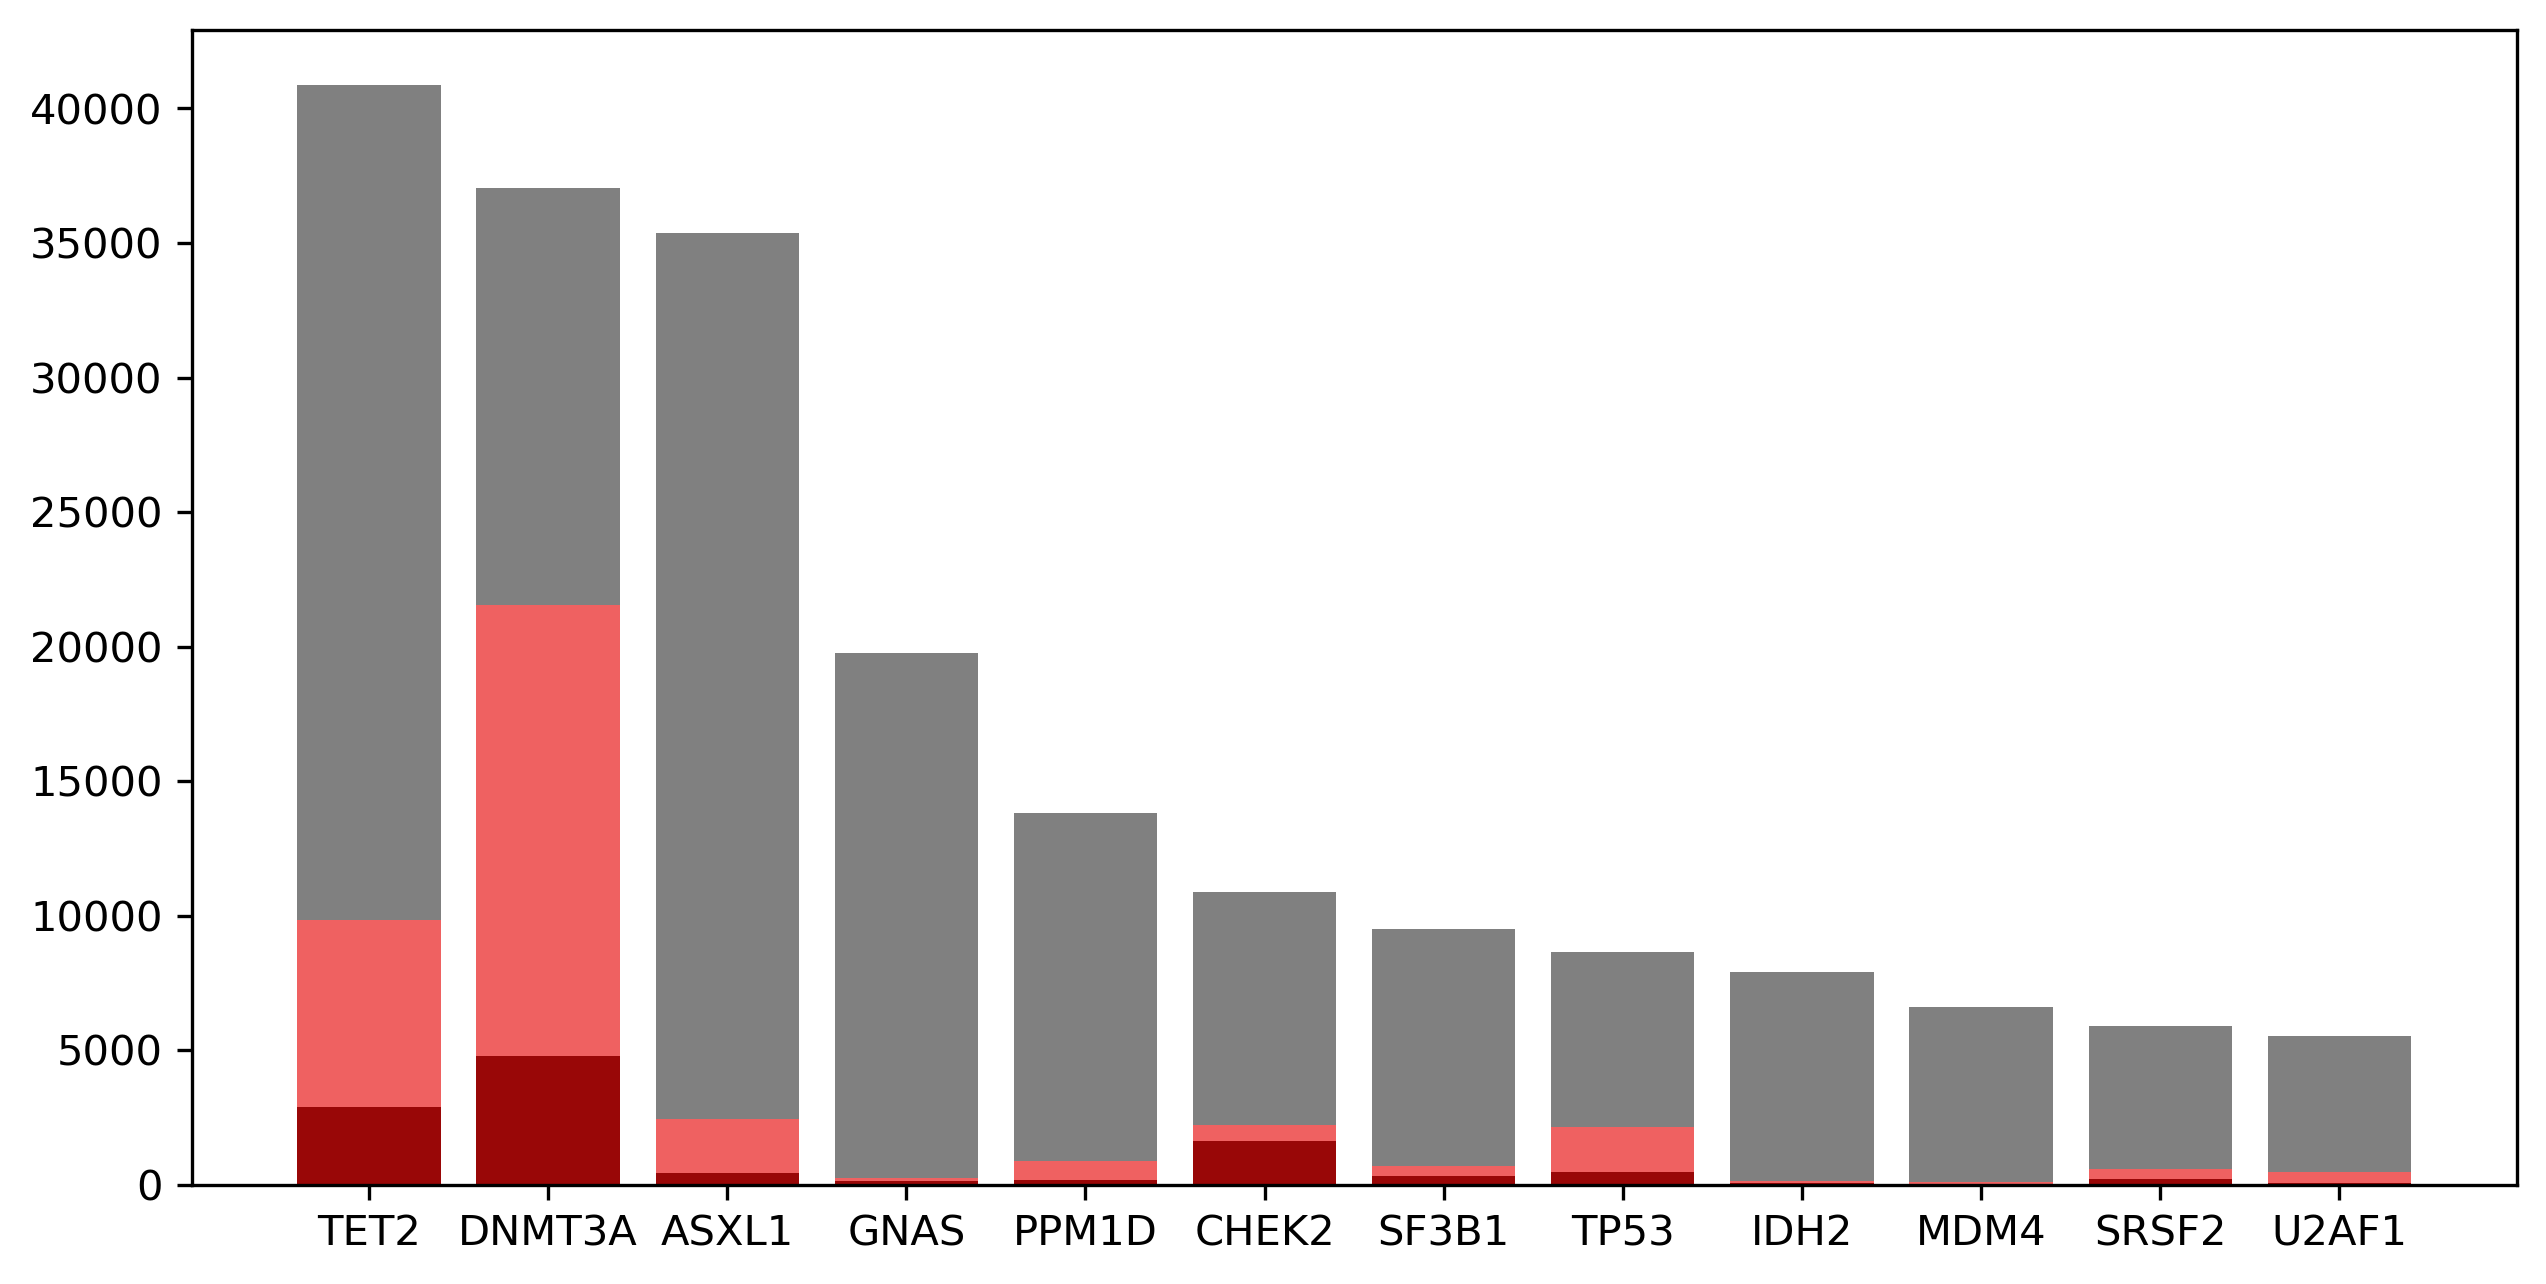

In [19]:
# importing package
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5), dpi=300)
    
# create data
x = Mut_case['Gene']
y1 = Mut_case['Passangers']
y2 = Mut_case['Driver_small']
y3 = Mut_case['Driver_big']
 
# plot bars in stack manner
plt.bar(x, y3, color='#990707')
plt.bar(x, y2, bottom=y3, color='#EF6161')
plt.bar(x, y1, bottom=y2+y3, color='grey')


plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.show()

### By mut type

In [20]:
boostDM_predictions_nonHN.Consequence.value_counts()

missense_variant                            182672
stop_gained                                  15247
missense_variant&splice_region_variant        2540
splice_region_variant&synonymous_variant      1167
stop_gained&splice_region_variant              231
Name: Consequence, dtype: int64

In [21]:
boostDM_predictions_nonHN[boostDM_predictions_nonHN['Drivers_12genes']==1].Consequence.value_counts()

missense_variant                            28508
stop_gained                                 11941
missense_variant&splice_region_variant        507
splice_region_variant&synonymous_variant      193
stop_gained&splice_region_variant             157
Name: Consequence, dtype: int64

In [22]:
Mut_case = []
for gene in boostDM_predictions_nonHN['SYMBOL'].unique():
    freq_driv = len(boostDM_predictions_nonHN[(boostDM_predictions_nonHN['SYMBOL']==gene) & (boostDM_predictions_nonHN['Drivers_12genes']==1)])
    freq_missense = len(boostDM_predictions_nonHN[(boostDM_predictions_nonHN['SYMBOL']==gene) & (boostDM_predictions_nonHN['Drivers_12genes']==1) &\
                                       (boostDM_predictions_nonHN['Consequence']=='missense_variant')])
    freq_nonsense = len(boostDM_predictions_nonHN[(boostDM_predictions_nonHN['SYMBOL']==gene) & (boostDM_predictions_nonHN['Drivers_12genes']==1) &\
                                        ((boostDM_predictions_nonHN['Consequence']=='stop_gained') |\
                                        (boostDM_predictions_nonHN['Consequence']=='stop_gained&splice_region_variant'))])
    freq_splicing = len(boostDM_predictions_nonHN[(boostDM_predictions_nonHN['SYMBOL']==gene) & (boostDM_predictions_nonHN['Drivers_12genes']==1) &\
                                        ((boostDM_predictions_nonHN['Consequence']=='missense_variant&splice_region_variant') |\
                                        (boostDM_predictions_nonHN['Consequence']=='splice_region_variant&synonymous_variant'))])
#     freq = len(maf_can_PASS_VAF_nonrep.groupby(['SYMBOL'])['case'].unique()[gene])
    Mut_case.append([gene, freq_driv, freq_missense, freq_nonsense, freq_splicing])

In [23]:
Mut_case = pd.DataFrame(Mut_case, columns = ['Gene', 'Drivers', 'Missense', 'Nonsense', 'Splicing']).sort_values('Drivers', ascending=False)
Mut_case.reset_index()

,index,Gene,Drivers,Missense,Nonsense,Splicing
0,2,DNMT3A,21547,17004,4100,443
1,1,TET2,9824,5818,3939,67
2,3,ASXL1,2459,0,2446,13
3,7,CHEK2,2212,1695,442,75
4,5,TP53,2153,1870,251,32
5,6,PPM1D,877,0,877,0
6,4,SF3B1,707,688,1,18
7,0,SRSF2,571,557,14,0
8,11,U2AF1,461,402,7,52
9,10,GNAS,251,245,6,0


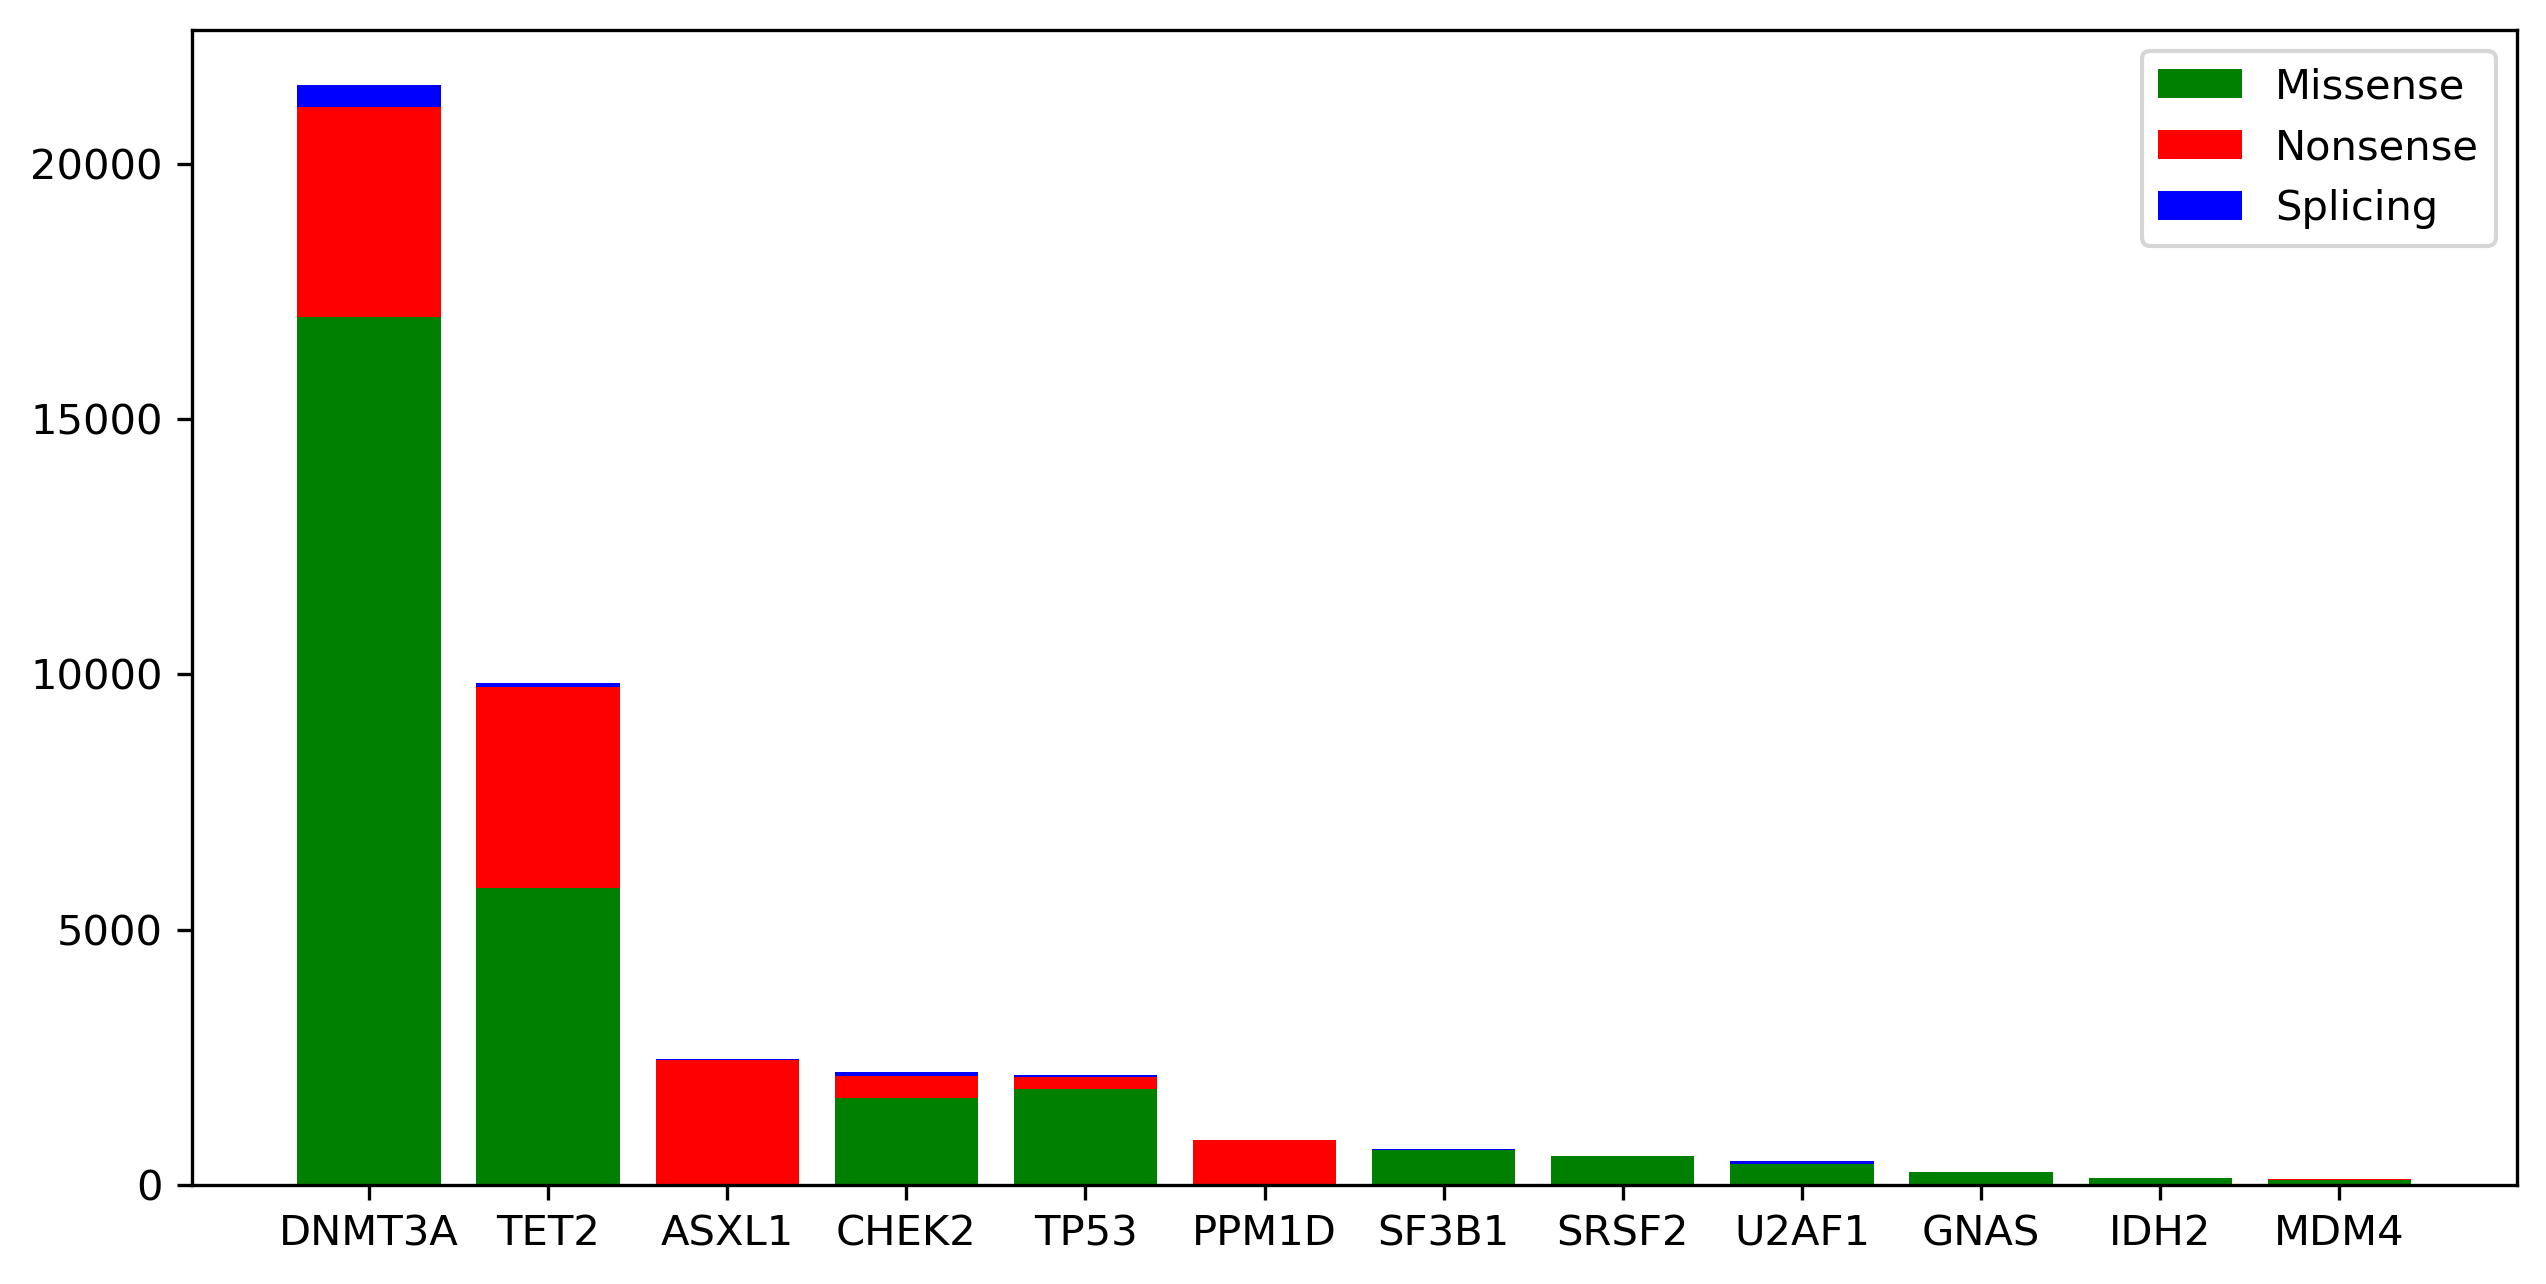

In [24]:
# importing package
import matplotlib.pyplot as plt
# plt.figure(figsize=(10, 5), dpi=300)
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)

labels= ['Missense', 'Nonsense', 'Splicing']
colors=['green', 'red', 'blue', 'purple']

# create data
x = Mut_case['Gene']
y1 = Mut_case['Missense']
y2 = Mut_case['Nonsense']
y3 = Mut_case['Splicing']
 
# plot bars in stack manner
plt.bar(x, y1, color='green')
plt.bar(x, y2, bottom=y1, color='red')
plt.bar(x, y3, bottom=y1+y2, color='blue')
plt.legend(labels=labels, fontsize=10)

plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
# plt.savefig('gene_profile.png', dpi=300)
plt.show()

In [25]:
print(Mut_case.Missense.sum())
print(Mut_case.Nonsense.sum())
print(Mut_case.Splicing.sum())

28508
12098
700


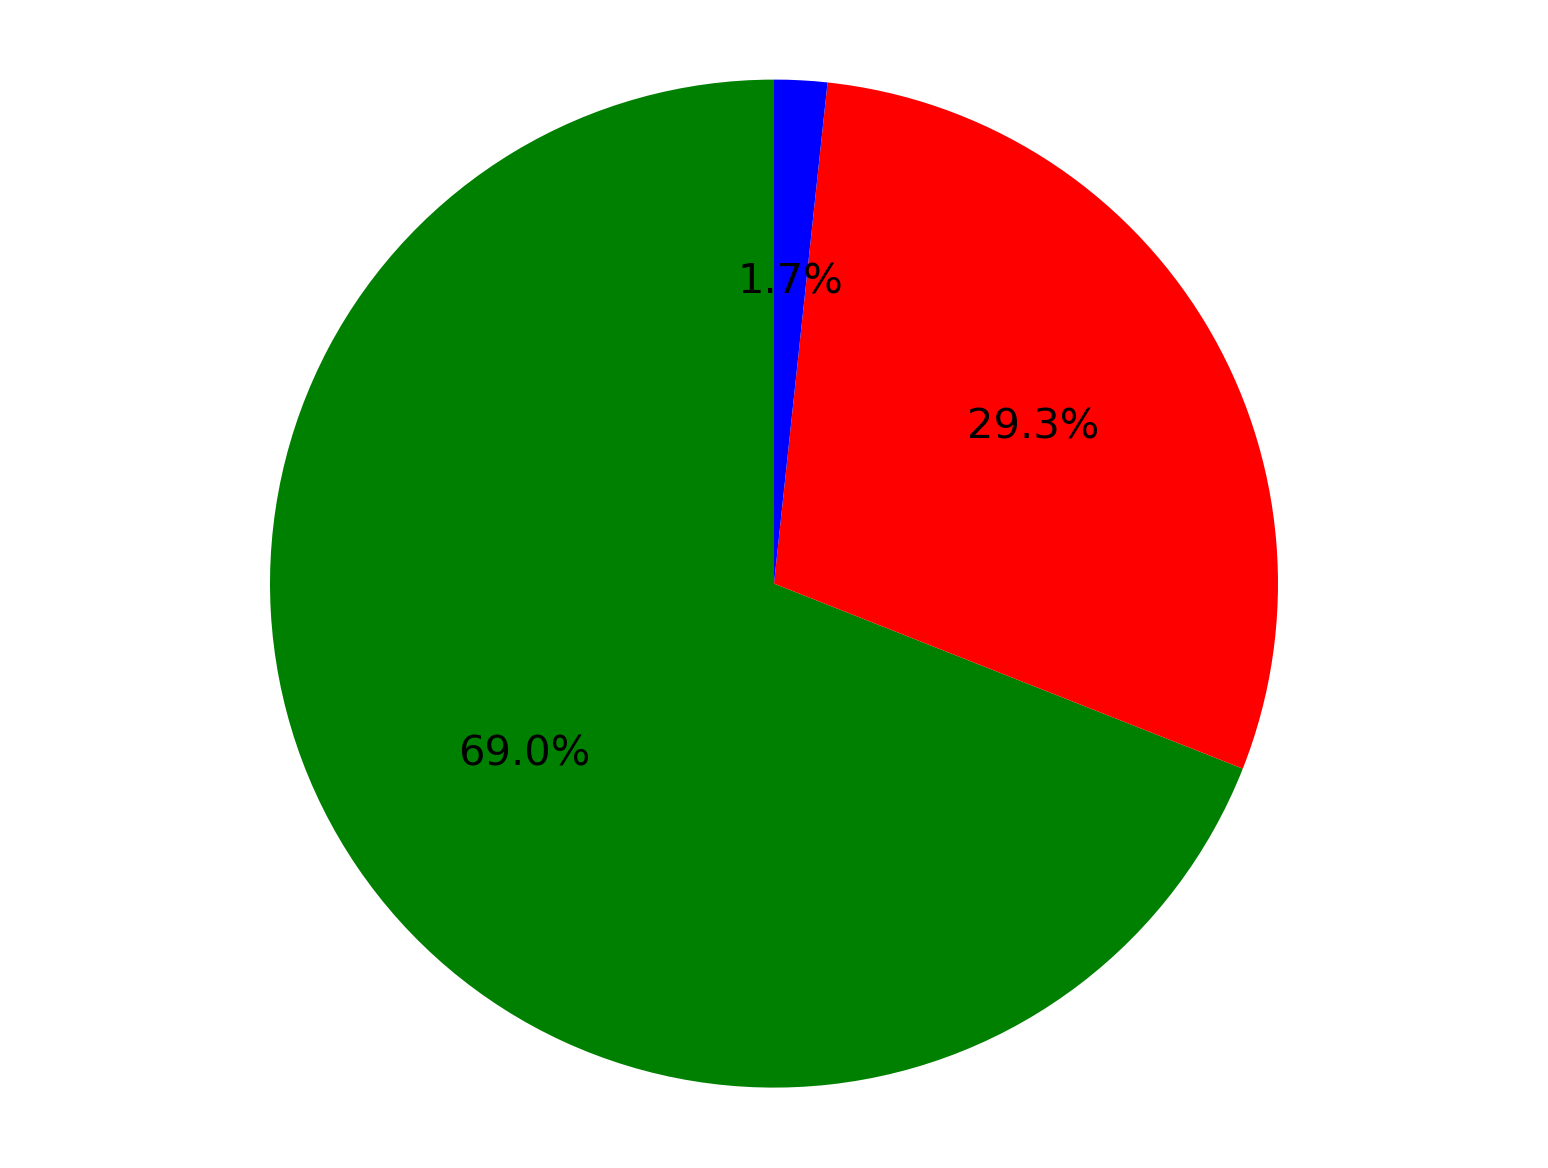

In [26]:
labels= ['Missense', 'Nonsense', 'Splicing']
colors=['green', 'red', 'blue', 'purple']
sizes= [sum(Mut_case['Missense']), sum(Mut_case['Nonsense']), sum(Mut_case['Splicing'])]

plt.pie(sizes,labels=None, colors=colors, startangle=90, autopct='%1.1f%%')
plt.axis('equal')
plt.show()

### By num mut

In [27]:
cases = boostDM_predictions_nonHN[boostDM_predictions_nonHN['Drivers_12genes']==1]['patient']
cases = cases.value_counts().reset_index()['patient'].value_counts().reset_index()
new_row = {'index':'>3', 'patient':cases[3:]['patient'].sum()}
nummut = cases[:3].append(new_row, ignore_index=True)
nummut

/tmp/jobs/jramis/9874679/ipykernel_48736/4237794431.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nummut = cases[:3].append(new_row, ignore_index=True)


,index,patient
0,1,35275
1,2,2582
2,3,222
3,>3,45


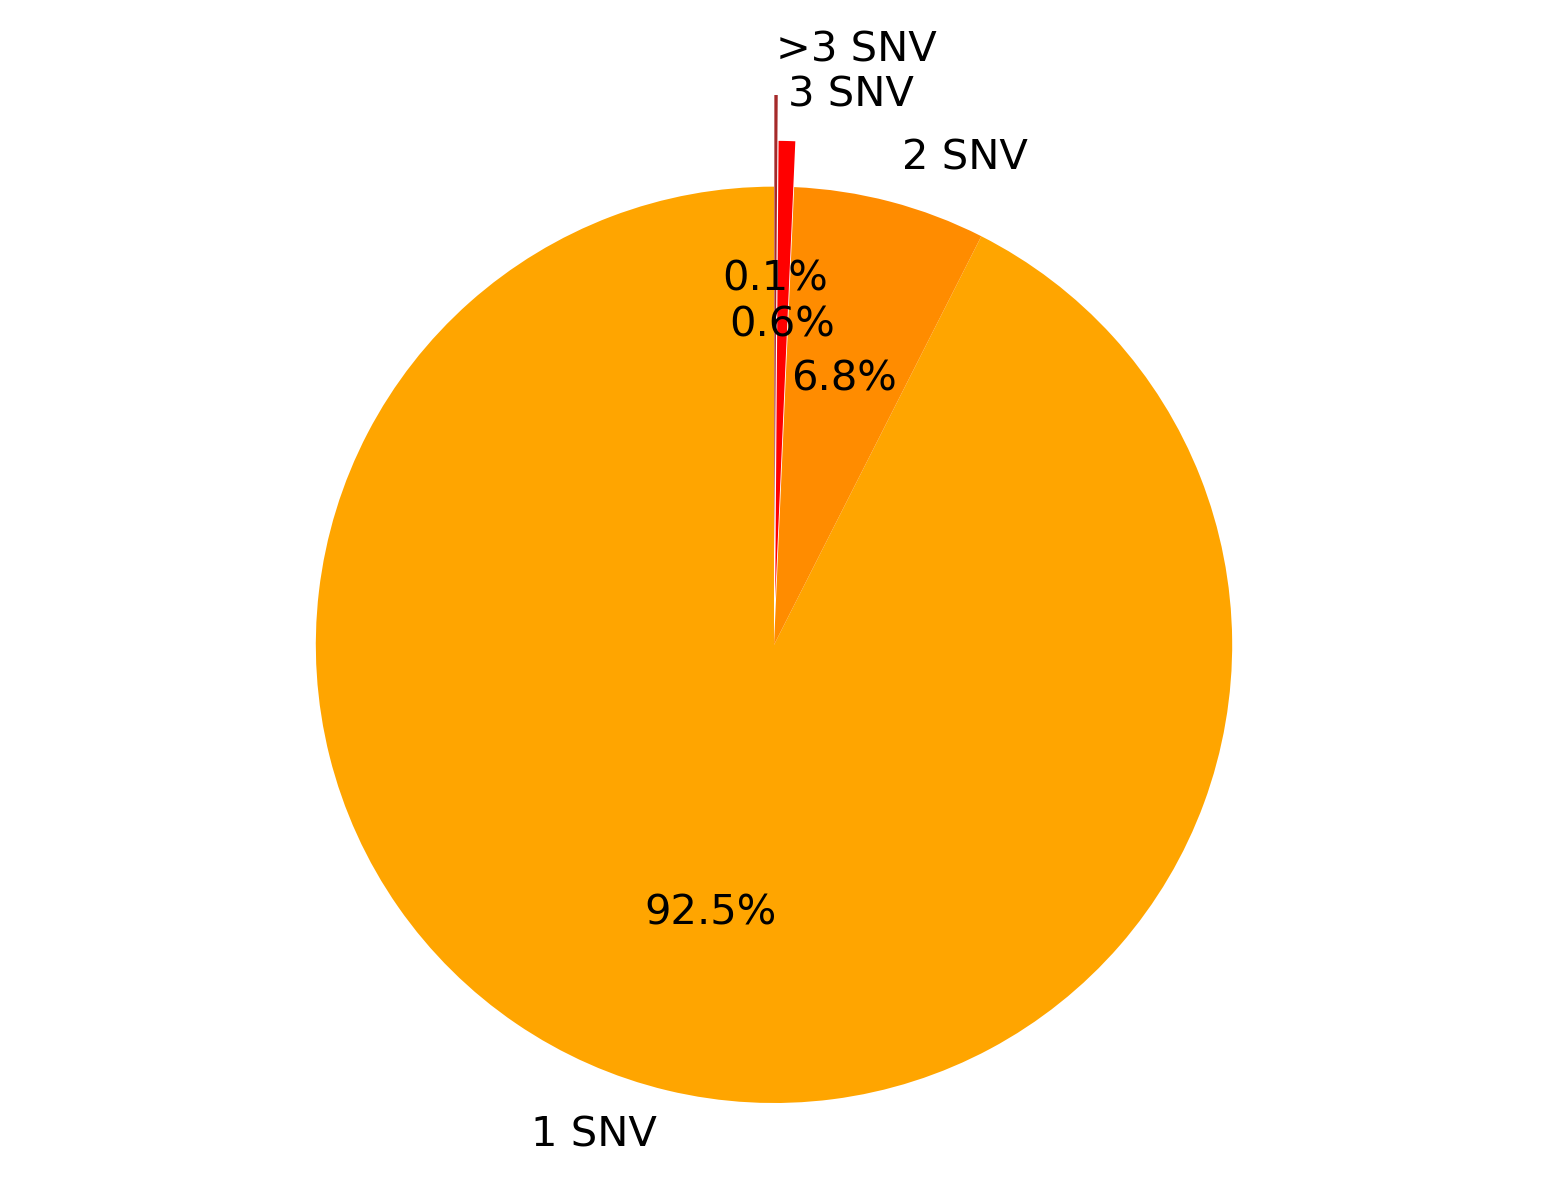

In [28]:
labels= ['1 SNV', '2 SNV', '3 SNV', '>3 SNV']
colors=['orange', 'darkorange', 'red', 'brown']
sizes= nummut['patient']
explode = [0, 0, 0.1, 0.2]
plt.pie(sizes,labels=labels, colors=colors, startangle=90, autopct='%1.1f%%', explode=explode)
plt.axis('equal')
plt.show()

### VAF distribution

(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(-0.2, 0, '−0.2'),
  Text(0.0, 0, '0.0'),
  Text(0.2, 0, '0.2'),
  Text(0.4000000000000001, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8'),
  Text(1.0000000000000002, 0, '1.0'),
  Text(1.2000000000000002, 0, '1.2')])

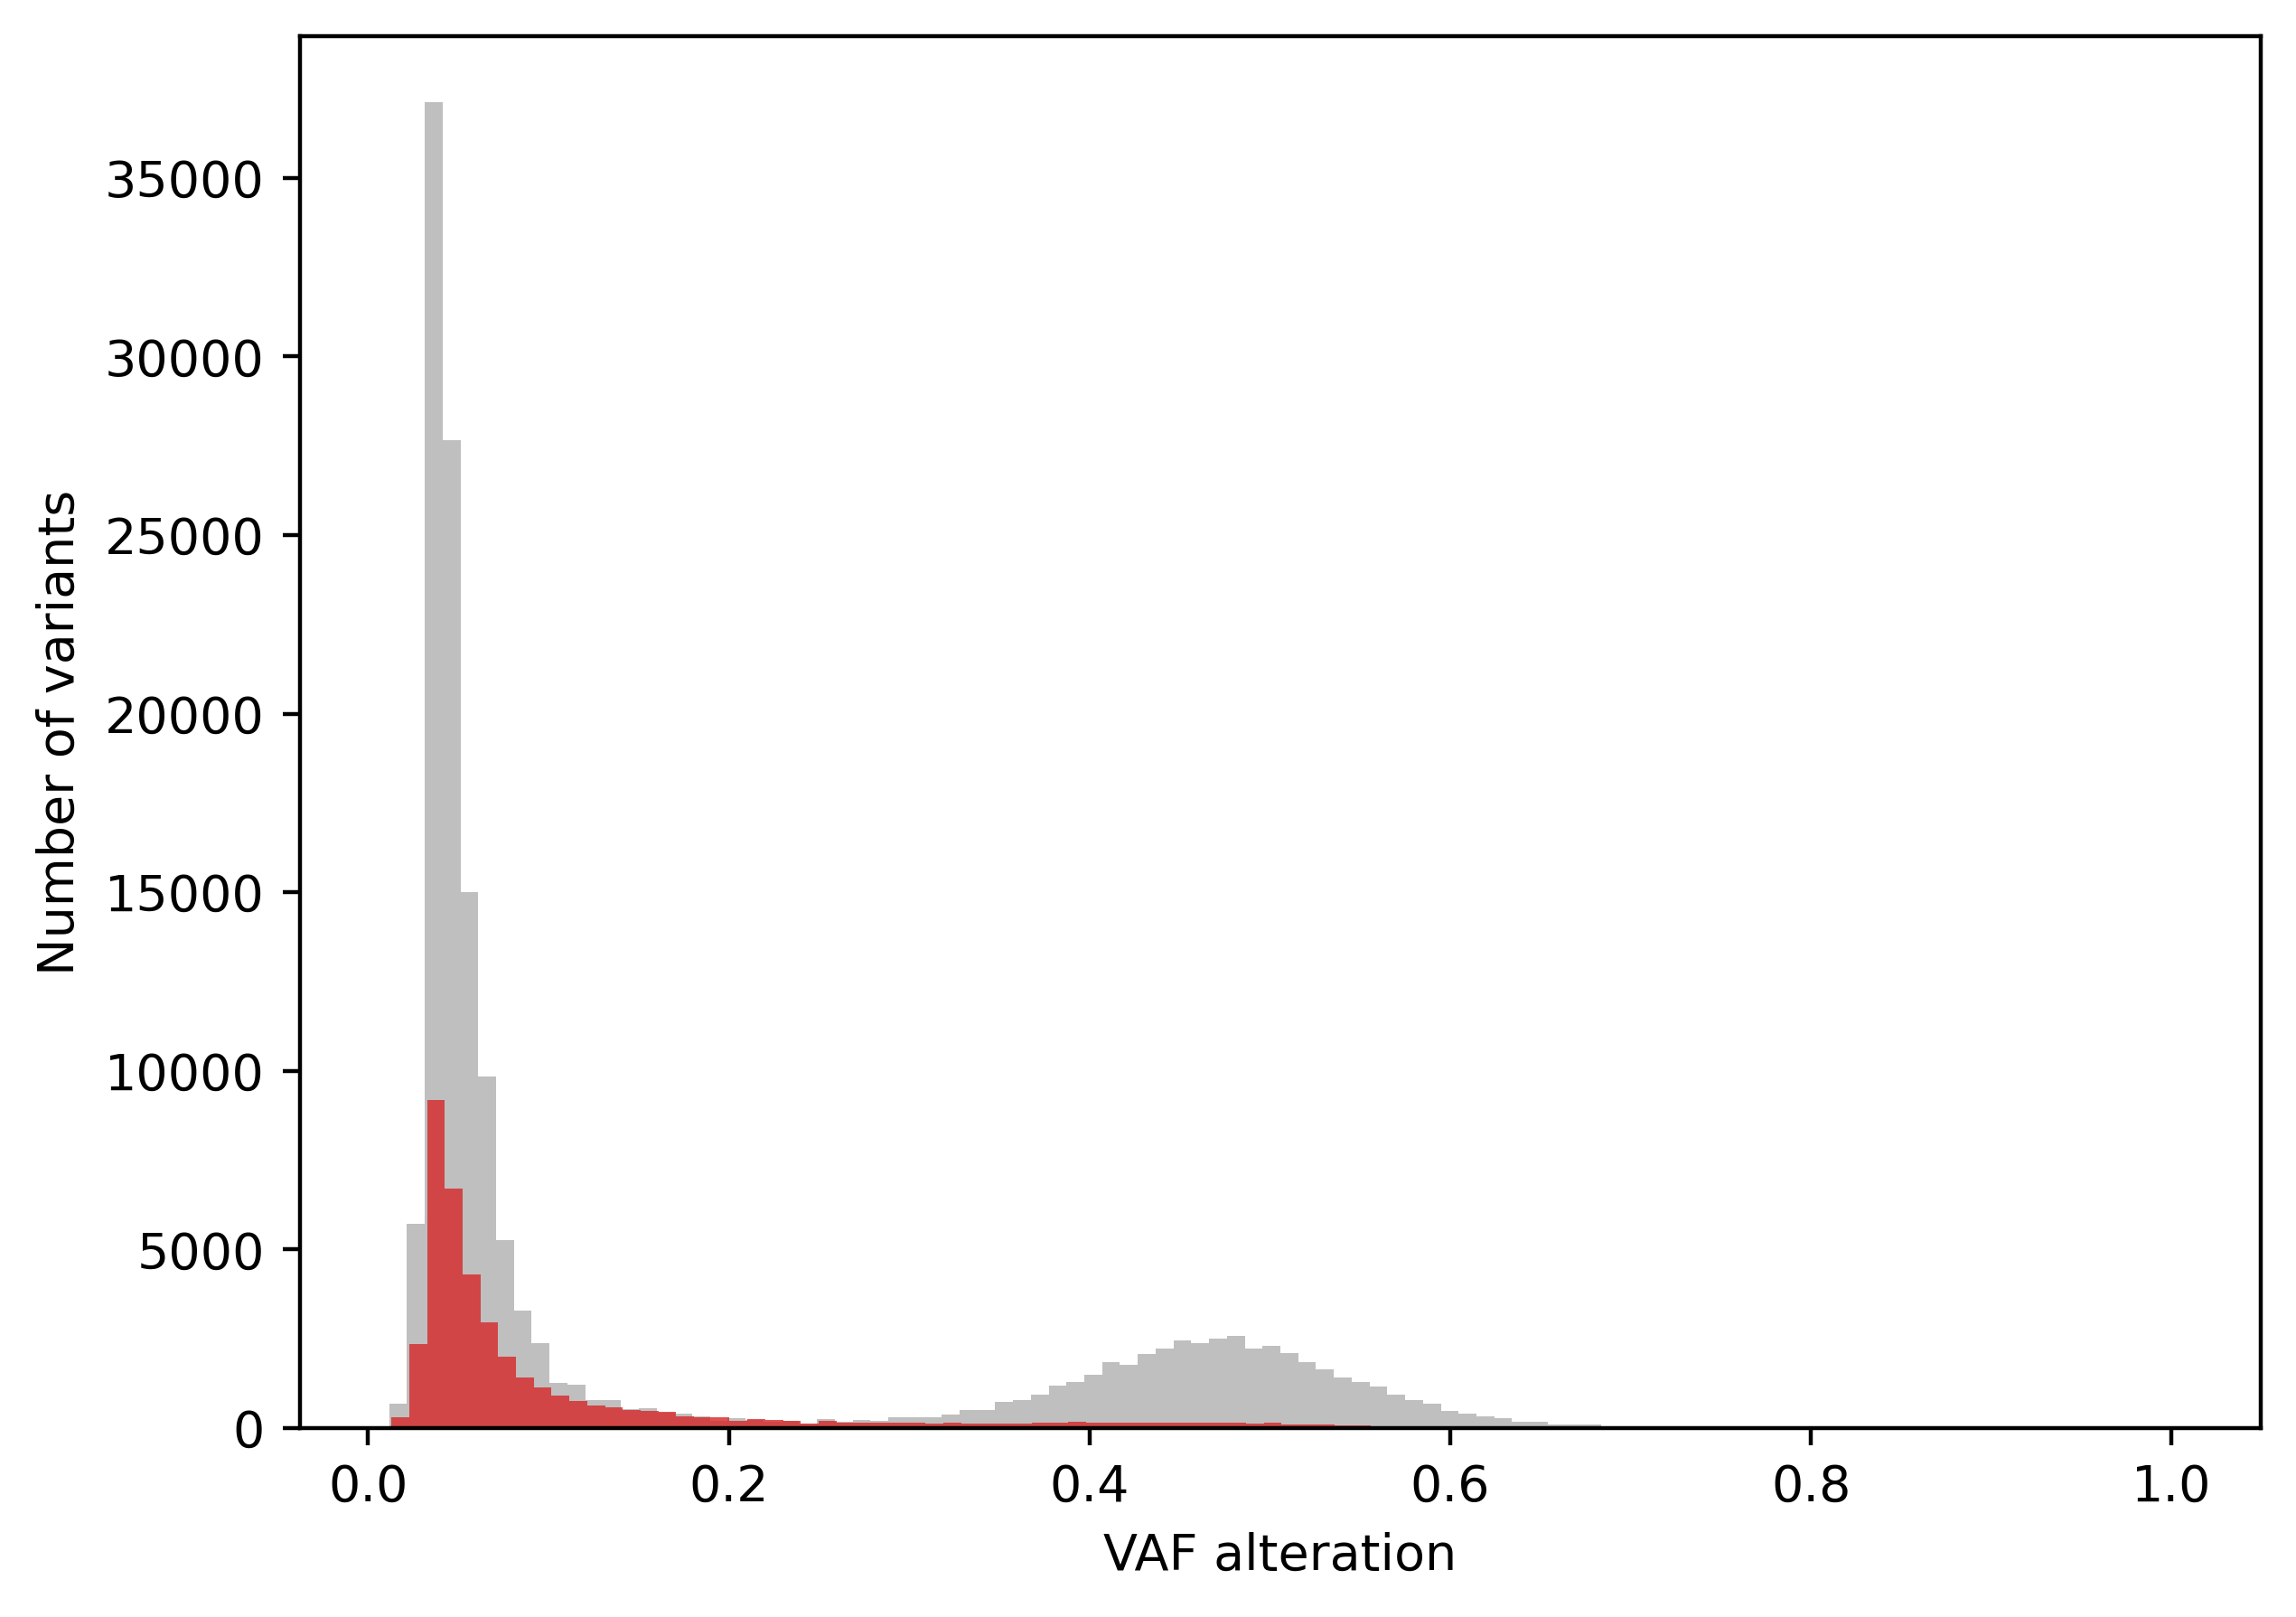

In [29]:
# Number of VAF variants per case
from matplotlib import pyplot

plt.figure(figsize=(7, 5), dpi=400)
pyplot.hist(boostDM_predictions_nonHN[boostDM_predictions_nonHN['Drivers_12genes']==0]['VAF_alt'],100, alpha=0.5, label='non_drivers', color='grey')
pyplot.hist(boostDM_predictions_nonHN[boostDM_predictions_nonHN['Drivers_12genes']==1]['VAF_alt'],100, alpha=0.8, label='drivers', color='tab:red')
pyplot.ylabel('Number of variants')
pyplot.xlabel('VAF alteration')
pyplot.legend(loc='upper right', fontsize = 10)
plt.legend('', frameon=False)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)

### Mutect 2 annotation

In [ ]:
driver_df = boostDM_predictions_nonHN[boostDM_predictions_nonHN['Drivers_12genes']==1].FILTER.value_counts().rename_axis('filter').reset_index(name='counts_driver')
passengers_df = boostDM_predictions_nonHN[boostDM_predictions_nonHN['Drivers_12genes']==0].FILTER.value_counts().rename_axis('filter').reset_index(name='counts_passenger')
all_pot = pd.merge(driver_df, passengers_df, on='filter', how='outer')[:16]

plt.figure(figsize=(10, 7))
X = all_pot['filter']
Ygirls = all_pot['counts_driver']
Zboys = all_pot['counts_passenger']
  
X_axis = np.arange(len(X))
plt.bar(X_axis - 0.2, Ygirls, 0.4, label = 'Drivers', color='red')
plt.bar(X_axis + 0.2, Zboys, 0.4, label = 'non-Drivers', color='grey')
  
plt.xticks(X_axis, X)
plt.xlabel("Filters")
plt.ylabel("Number of SNV")
plt.title("Number of mutations")
plt.xticks(rotation = 90, size=10)
plt.legend()
plt.show()

### VAF distribution per gene

In [31]:
genes15_col = {
           'DNMT3A':'#023E8A',
           'TET2':'#48CAE4',
           'ASXL1':'#0096C7',
           'CHEK2':'#F8961E',
           'TP53':'#F94144',
           'PPM1D':'#F3722C',
           'MDM4':'#F9C74F',
           'SF3B1':'#90BE6D',
           'SRSF2':'#43AA8B',
           'U2AF1':'#4D908E',   
           'GNAS':'#7209B7',
           'IDH2':'#B5179E'      
           }

In [32]:
my_order = boostDM_predictions_nonHN[boostDM_predictions_nonHN['Drivers_12genes']==1].groupby(by=["SYMBOL"])["VAF_alt"].median().sort_values(ascending=True).index
[genes15_col[x] for x in my_order.tolist()]

['#0096C7',
 '#F3722C',
 '#4D908E',
 '#023E8A',
 '#F94144',
 '#48CAE4',
 '#43AA8B',
 '#F9C74F',
 '#90BE6D',
 '#7209B7',
 '#B5179E',
 '#F8961E']

In [33]:
boostDM_predictions_nonHN.VAF_alt.max()

1.00

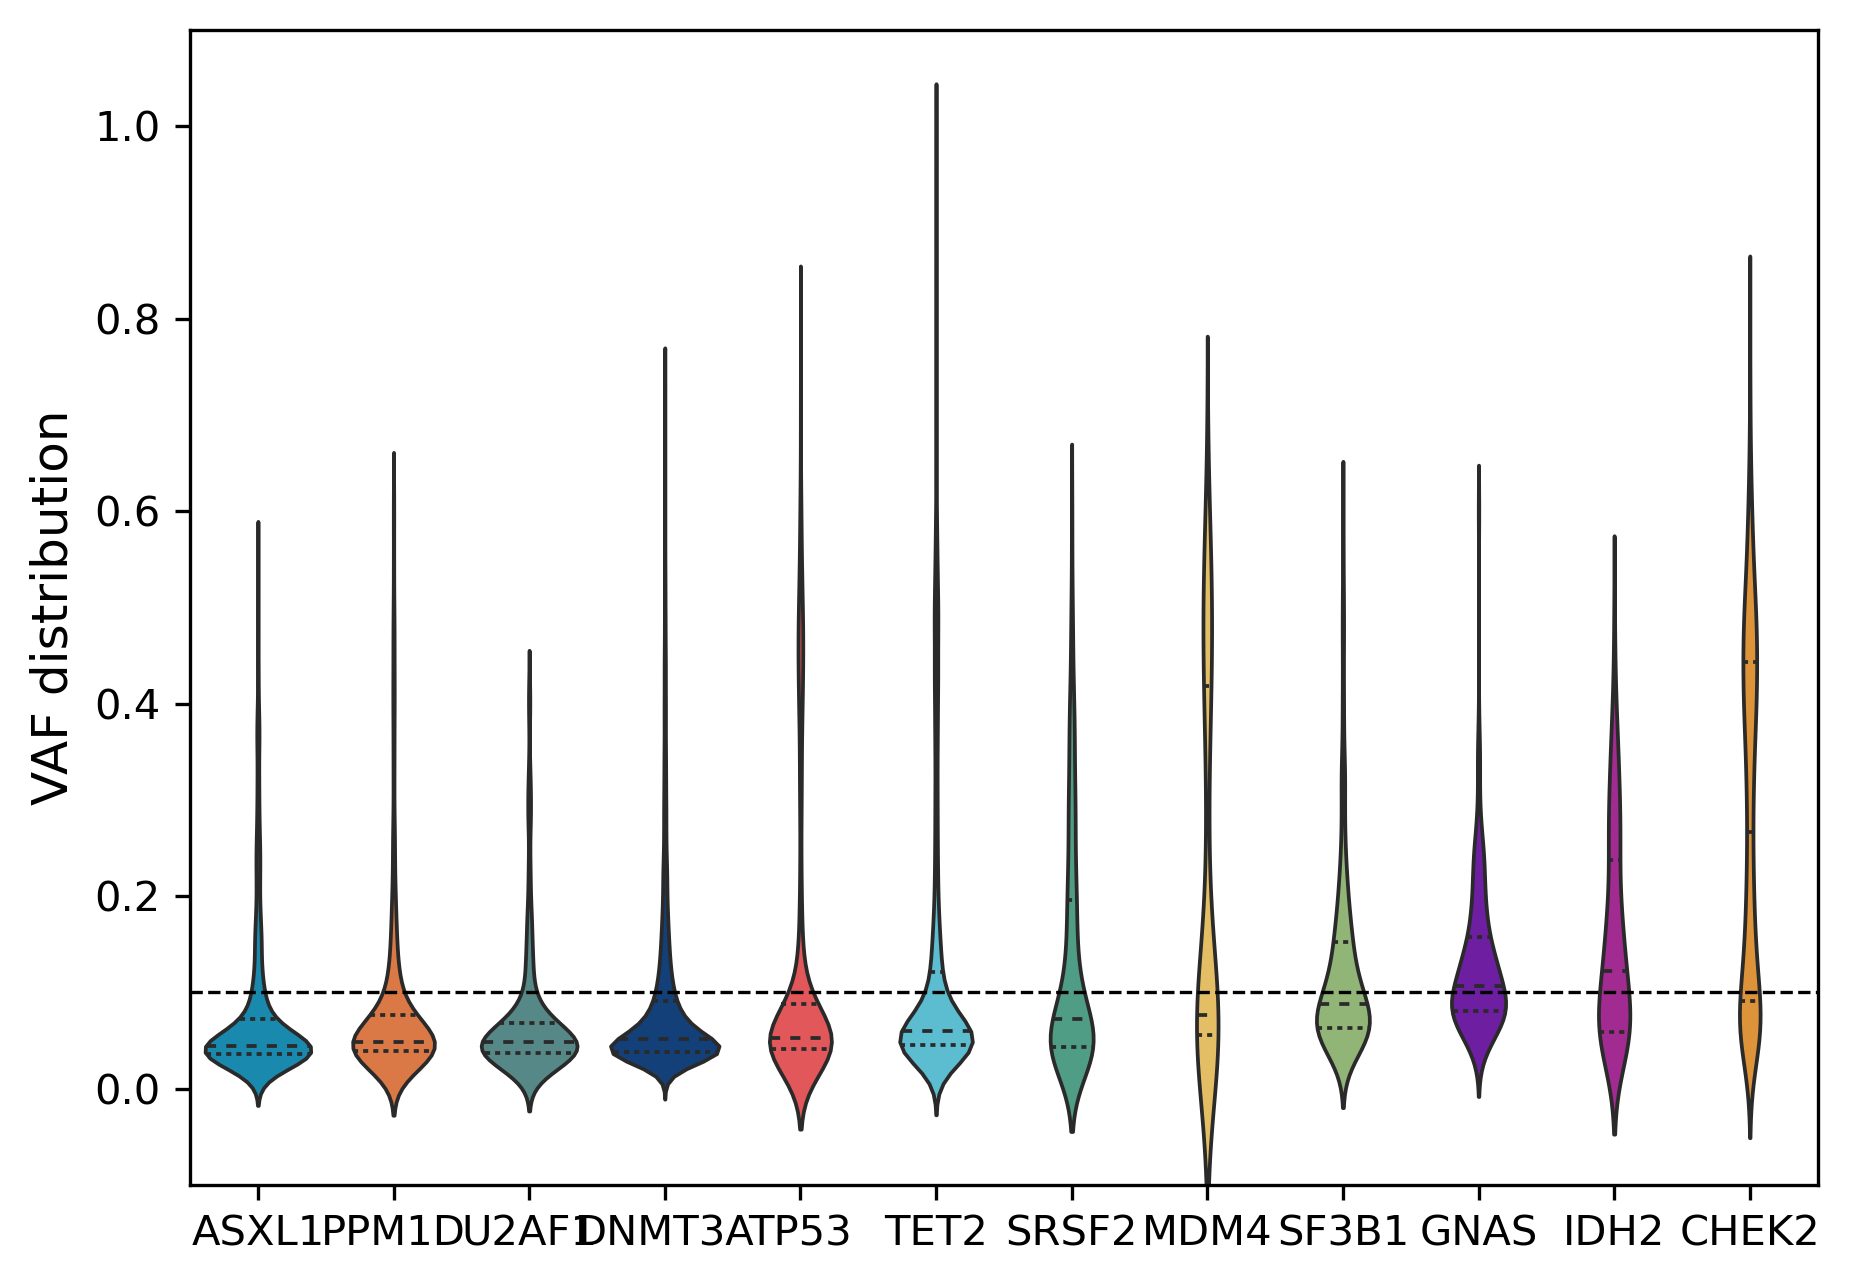

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5), dpi=300)

my_order = boostDM_predictions_nonHN[boostDM_predictions_nonHN['Drivers_12genes']==1].groupby(by=["SYMBOL"])["VAF_alt"].median().sort_values(ascending=True).index
sns.violinplot(data=boostDM_predictions_nonHN[boostDM_predictions_nonHN['Drivers_12genes']==1], x="SYMBOL", y="VAF_alt", inner='quartile', linewidth=0.9, palette=genes15_col, order=my_order)
plt.yticks(fontsize=10)
plt.ylabel('VAF distribution', size = 12)
plt.xticks(fontsize=10)
plt.xlabel('', size = 10)
plt.axhline(y=0.1, linewidth=0.8, linestyle='--', color='black')
plt.ylim(-.1, 1.1)
plt.show()